In [1]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [2]:
#Import required packages
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.layers import Input, Layer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.metrics import BinaryAccuracy, CategoricalAccuracy, Recall
from keras.layers import Flatten
import keras_tuner as kt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 32
    EPOCHS = 25
    EPOCHS_FINE_TUNE = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

In [5]:
MAIN_FOLDER = f'/kaggle/input/rsna-preprocessed'

In [6]:
# train
dataframe = pd.read_csv(f"{MAIN_FOLDER}/train.csv")
dataframe["image_path"] = f"{MAIN_FOLDER}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512


In [7]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

In [9]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomContrast(factor=0.1),
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [10]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([32, 256, 256, 3]),
 [TensorShape([32, 1]),
  TensorShape([32, 1]),
  TensorShape([32, 3]),
  TensorShape([32, 3]),
  TensorShape([32, 3])])

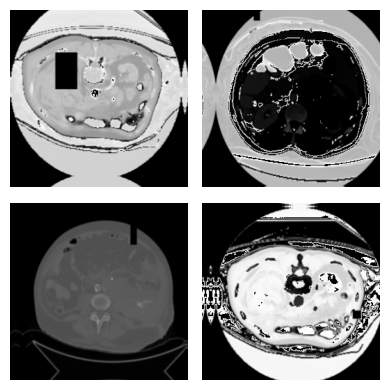

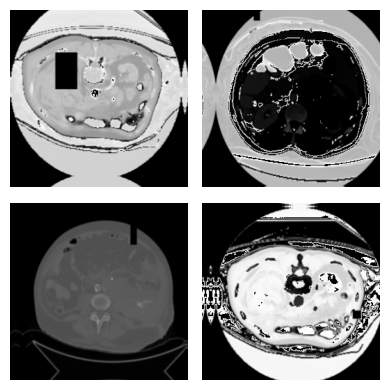

In [11]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

In [12]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=240800
warmup_steps=24080
decay_steps=216720


In [13]:
def build_model(hp):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    ## Adjust hyperparameters
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 1e-5])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd','rmsprop'])
    hp_activation = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'silu'])
    
    # Define Backbone
    backbone = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
    )
    backbone.trainable = False
    x = backbone(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Define shared layers
    x_shared = Dense(32, activation=hp_activation)(x)
    x_shared = Flatten()(x_shared)

    # Define heads
    out_bowel = Dense(1, name='bowel', activation='sigmoid')(x_shared)
    out_extra = Dense(1, name='extra', activation='sigmoid')(x_shared)
    out_liver = Dense(3, name='liver', activation='softmax')(x_shared)
    out_kidney = Dense(3, name='kidney', activation='softmax')(x_shared)
    out_spleen = Dense(3, name='spleen', activation='softmax')(x_shared)

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print('[INFO] Building the model...')
    model = Model(inputs=inputs, outputs=outputs)

    # Learning rate schedule
    initial_learning_rate = hp_learning_rate

    learning_rate_schedule = CosineDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        alpha=0.0
    )

    # Define the optimizer choices
    optimizer_choices = {
        'adam': Adam,
        'sgd': SGD,
        'rmsprop': RMSprop,
    }

    # Select the optimizer class based on the hyperparameter value
    selected_optimizer = optimizer_choices[hp_optimizer]

    # Instantiate the optimizer with the specified learning rate
    optimizer = selected_optimizer(learning_rate=learning_rate_schedule)
    
    loss = {
        "bowel": BinaryCrossentropy(),
        "extra": BinaryCrossentropy(),
        "liver": CategoricalCrossentropy(),
        "kidney": CategoricalCrossentropy(),
        "spleen": CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": [BinaryAccuracy(), Recall()],
        "extra": [BinaryAccuracy(), Recall()],
        "liver": [CategoricalAccuracy(), Recall()],
        "kidney": [CategoricalAccuracy(), Recall()],
        "spleen": [CategoricalAccuracy(), Recall()],
    }

    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model


In [14]:
# Define the custom objective
custom_objective = kt.Objective("val_loss", direction="min")

# Define the tuner
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=custom_objective,
    max_trials=10,
    num_initial_points=2,
    alpha=1e-2,
    beta=3,
)

# Start the search
tuner.search(
    train_ds,
    epochs=3,
    validation_data=val_ds,
)

Trial 10 Complete [00h 04m 29s]
val_loss: 3.329272747039795

Best val_loss So Far: 3.3109045028686523
Total elapsed time: 00h 46m 39s


In [15]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

[INFO] Building the model...
[INFO] Compiling the model...


In [16]:
earlystopping = EarlyStopping(monitor="val_loss",
                                mode="min", patience=3,
                                restore_best_weights=True)

# train
print("[INFO] Training...")
history = best_model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
    callbacks=[earlystopping]
)

[INFO] Training...
Epoch 1/25
301/301 [==============================] - 93s 288ms/step - loss: 2.9407 - bowel_loss: 0.3953 - extra_loss: 0.5477 - liver_loss: 0.4111 - kidney_loss: 0.6540 - spleen_loss: 0.9326 - bowel_binary_accuracy: 0.8721 - bowel_recall_5: 0.7548 - extra_binary_accuracy: 0.7093 - extra_recall_6: 0.7546 - liver_categorical_accuracy: 0.8628 - liver_recall_7: 0.8407 - kidney_categorical_accuracy: 0.7787 - kidney_recall_8: 0.7494 - spleen_categorical_accuracy: 0.6449 - spleen_recall_9: 0.6282 - val_loss: 3.9191 - val_bowel_loss: 1.2222 - val_extra_loss: 0.6292 - val_liver_loss: 0.5613 - val_kidney_loss: 0.5814 - val_spleen_loss: 0.9251 - val_bowel_binary_accuracy: 0.5205 - val_bowel_recall_5: 1.0000 - val_extra_binary_accuracy: 0.6967 - val_extra_recall_6: 1.0000 - val_liver_categorical_accuracy: 0.8697 - val_liver_recall_7: 0.8697 - val_kidney_categorical_accuracy: 0.8113 - val_kidney_recall_8: 0.8113 - val_spleen_categorical_accuracy: 0.6773 - val_spleen_recall_9: 0.6

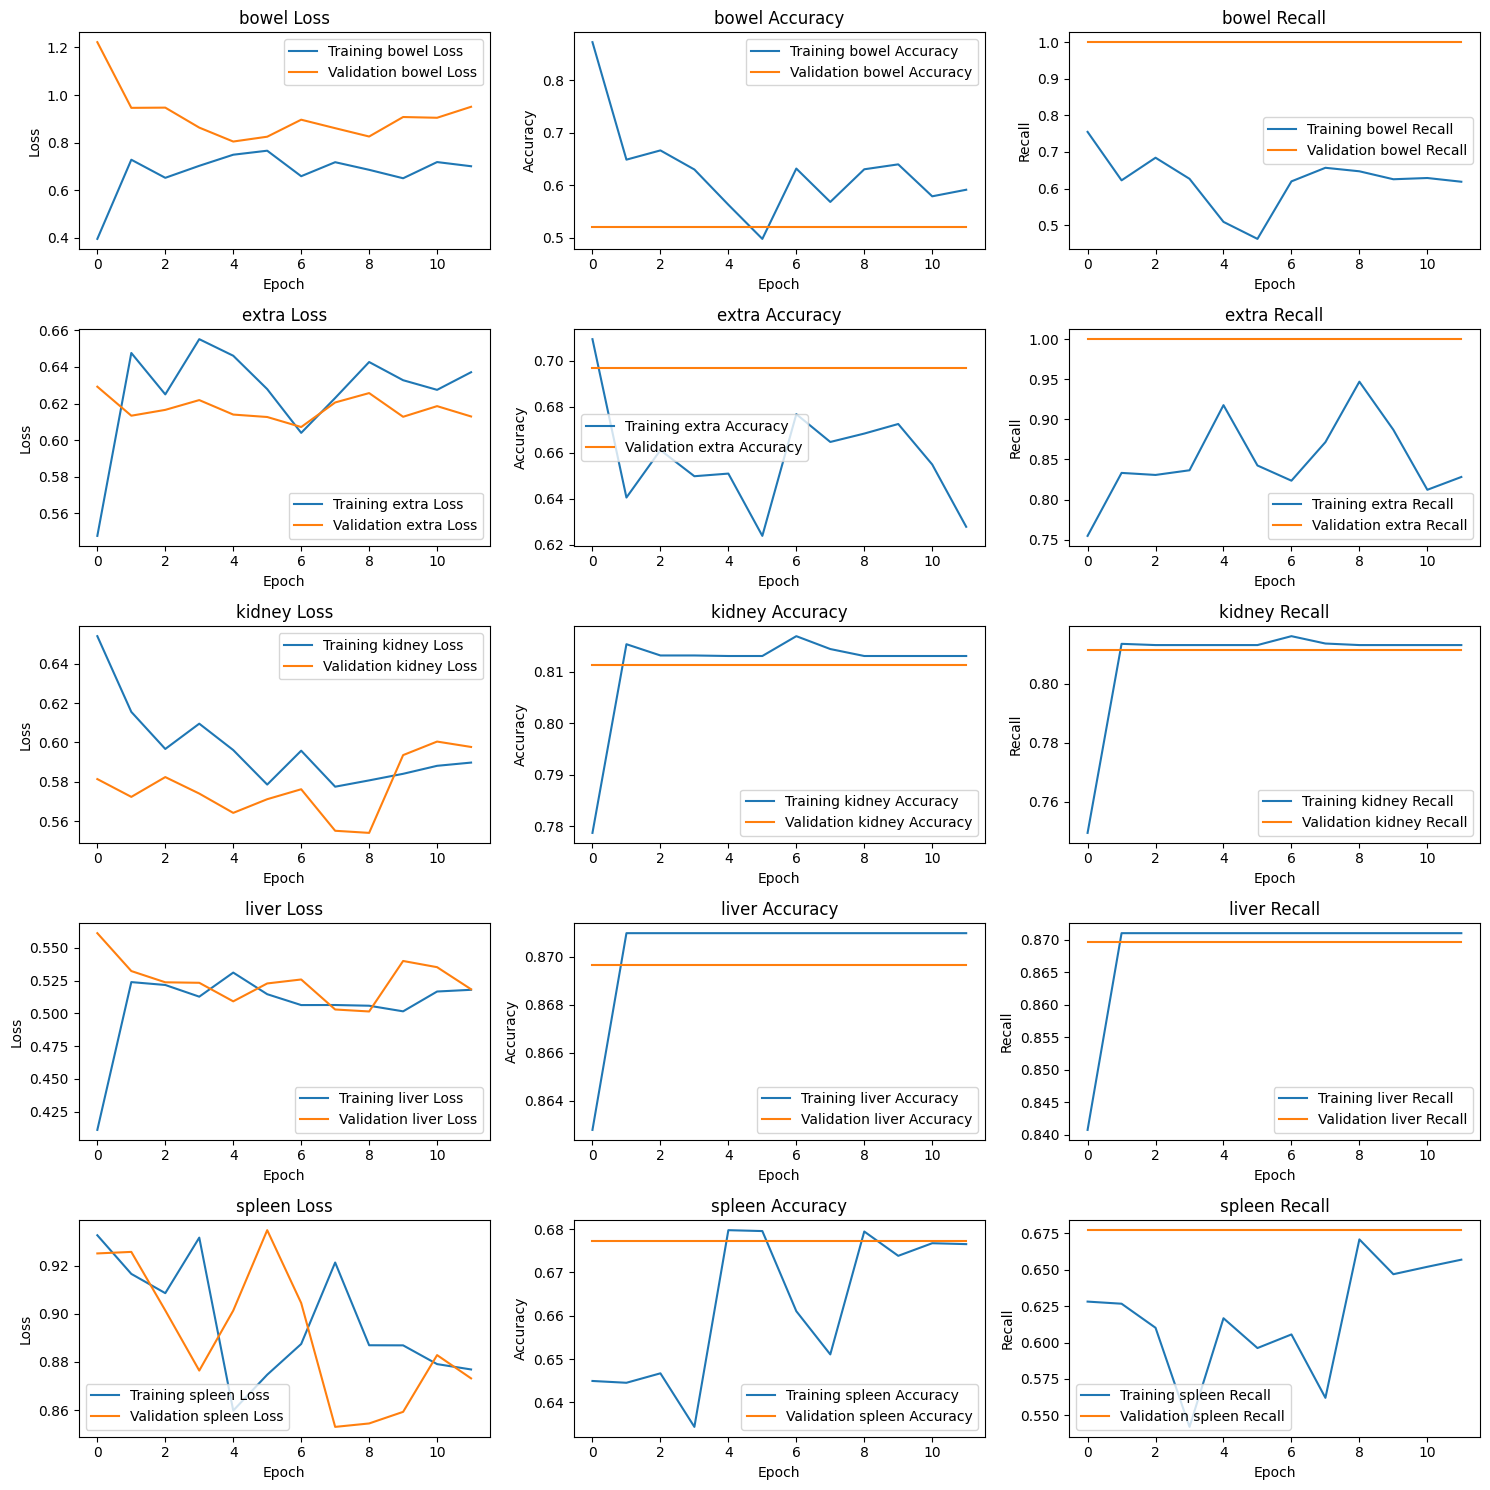

In [17]:
# Create a 5x3 grid for the subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training loss
    axes[i*3].plot(history.history[name + '_loss'], label='Training ' + name + ' Loss')
    # Plot validation loss
    axes[i*3].plot(history.history['val_' + name + '_loss'], label='Validation ' + name + ' Loss')
    axes[i*3].set_title(name + ' Loss')
    axes[i*3].set_xlabel('Epoch')
    axes[i*3].set_ylabel('Loss')
    axes[i*3].legend()

    # Identify the correct name for accuracy metric
    acc_name = name + '_binary_accuracy' if name in ['bowel', 'extra'] else name + '_categorical_accuracy'

    # Plot training accuracy
    axes[i*3 + 1].plot(history.history[acc_name], label='Training ' + name + ' Accuracy')
    # Plot validation accuracy
    axes[i*3 + 1].plot(history.history['val_' + acc_name], label='Validation ' + name + ' Accuracy')
    axes[i*3 + 1].set_title(name + ' Accuracy')
    axes[i*3 + 1].set_xlabel('Epoch')
    axes[i*3 + 1].set_ylabel('Accuracy')
    axes[i*3 + 1].legend()

    # Find the recall metric with the highest epoch value
    recall_metric = [metric for metric in history.history.keys() if name + '_recall' in metric]
    max_recall_epoch = max(recall_metric, key=lambda x: int(x.split('_')[-1]))
    
    # Plot training recall for the latest epoch
    axes[i*3 + 2].plot(history.history[max_recall_epoch], label='Training ' + name + ' Recall')
    # Plot validation recall for the latest epoch
    axes[i*3 + 2].plot(history.history['val_' + max_recall_epoch], label='Validation ' + name + ' Recall')
    axes[i*3 + 2].set_title(name + ' Recall')
    axes[i*3 + 2].set_xlabel('Epoch')
    axes[i*3 + 2].set_ylabel('Recall')
    axes[i*3 + 2].legend()

plt.tight_layout()
plt.show()


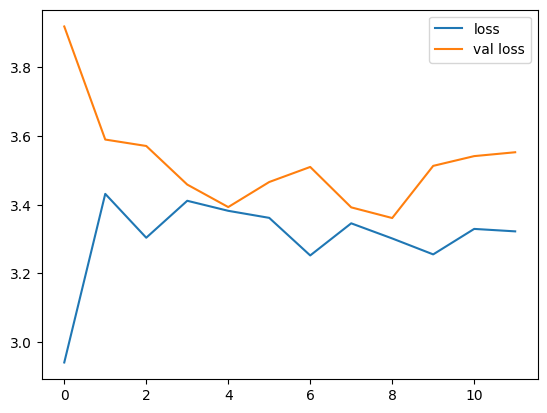

In [18]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [19]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_binary_accuracy'][best_epoch]
best_recall_bowel = history.history['val_bowel_recall_5'][best_epoch]

best_acc_extra = history.history['val_extra_binary_accuracy'][best_epoch]
best_recall_extra = history.history['val_extra_recall_6'][best_epoch]

best_acc_liver = history.history['val_liver_categorical_accuracy'][best_epoch]
best_recall_liver = history.history['val_liver_recall_7'][best_epoch]

best_acc_kidney = history.history['val_kidney_categorical_accuracy'][best_epoch]
best_recall_kidney = history.history['val_kidney_recall_8'][best_epoch]

best_acc_spleen = history.history['val_spleen_categorical_accuracy'][best_epoch]
best_recall_spleen = history.history['val_spleen_recall_9'][best_epoch]

# Find mean accuracy and mean recall
best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])
best_recall = np.mean([best_recall_bowel, best_recall_extra, best_recall_liver, best_recall_kidney, best_recall_spleen])

print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Recall : {best_recall:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : Acc={best_acc_bowel:.3f}, Recall={best_recall_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : Acc={best_acc_extra:.3f}, Recall={best_recall_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : Acc={best_acc_liver:.3f}, Recall={best_recall_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : Acc={best_acc_kidney:.3f}, Recall={best_recall_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : Acc={best_acc_spleen:.3f}, Recall={best_recall_spleen:.3f}')


>>>> BEST Loss  : 3.361
>>>> BEST Acc   : 0.715
>>>> BEST Recall : 0.872
>>>> BEST Epoch : 8

ORGAN Acc:
  >>>> Bowel           : Acc=0.520, Recall=1.000
  >>>> Extravasation   : Acc=0.697, Recall=1.000
  >>>> Liver           : Acc=0.870, Recall=0.870
  >>>> Kidney          : Acc=0.811, Recall=0.811
  >>>> Spleen          : Acc=0.677, Recall=0.677


In [20]:
# Save the model
best_model.save_weights("rsna-atd-xception_weights.h5")

In [21]:
# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# Print or use the best hyperparameters
print("Best Hyperparameters:")
print(best_hps)

Best Hyperparameters:
{'learning_rate': 0.001, 'optimizer': 'adam', 'activation': 'sigmoid'}
